# Goal: Get all Data from volumes that have been looked at!

In [1]:
import pandas as pd

In [3]:
d1 = pd.read_json("data_from_0_to_1000")
d2 = pd.read_json("data_from_1000_to_2500")
d3 = pd.read_json("data_from_2500_to_4500")
d4 = pd.read_json("data_from_4500_to_5999")

In [5]:
data = pd.concat( [d1, d2, d3, d4], ignore_index=True)

In [15]:
data.to_json("all_relevant_journal_data.pd")

In [8]:
grouped = data.groupby(by="journal_name")

In [70]:
import json
import unidecode 

with open("journal_name_to_standard.json") as f:
    journal_name_standard = json.load(f)
    
with open("issn_journal_map.json") as f:
    issn_journal = json.load(f)
    
with open("issn_vol_iss_map.json") as f:
    issn_vol_iss = json.load(f)

In [71]:
journal_name_standard = {key.lower():val.lower() for key, val in journal_name_standard.items()}

Get all data from journals for which we have at least one volume

In [74]:
from collections import defaultdict
cleaned_groups = defaultdict(lambda: pd.Int64Index([])) # Sometimes group occur more than once due to capitalisation #Default to lower

for name, group in grouped.groups.items():
    name = name.strip().lower()
    
    if name in journal_name_standard.keys():
        name = journal_name_standard[name]
        
    standardised_name = name.strip().lower()
    
    cleaned_groups[standardised_name] = cleaned_groups[standardised_name].union(group)

In [108]:
journal_name_standard

{'the journal of applied ecology': 'journal of applied ecology',
 'agriculture ecosystems and environment': 'agriculture, ecosystems & environment',
 'agriculture, ecosystems and environment': 'agriculture, ecosystems & environment',
 'restoration ecology': 'restoration ecology',
 'the journal of wildlife management': 'journal of wildlife management',
 'waterbirds: the international journal of waterbird biology': 'waterbirds',
 'animal conservation': 'animal conservation',
 'vegetatio': 'vegetatio',
 'ices journal of marine science: journal du conseil': 'ices journal of marine science',
 'the journal of animal ecology': 'journal of animal ecology',
 'journal of insect conservation': 'journal of insect conservation',
 'acta oecologica': 'acta oecologica',
 'plos one': 'plos one',
 'the journal of ecology': 'journal of ecology',
 'mammalian biology - zeitschrift für säugetierkunde': 'mammalian biology',
 'animal welfare': 'animal welfare',
 'mammalia': 'mammalia',
 'knowledge and managem

Get a mapping between standardised names and volumes we have in pos data

In [112]:
def standardise_journal_name(name):
    if name is None:
        return None
    name = unidecode.unidecode(name.strip()).lower()
    if name in journal_name_standard.keys():
        return journal_name_standard[name]
    else:
        return name

In [75]:
name_issn = {unidecode.unidecode(name.strip()).lower() : issn for issn, name in issn_journal.items()}

In [76]:
name_vols = {name: issn_vol_iss[issn] for name, issn in name_issn.items() if issn in issn_vol_iss}

In [77]:
name_vols = {name : {vol for vol, iss in vols} for name, vols in name_vols.items()} #extract only vols

Extract the relevant volumes from the journals

In [78]:
journals_relevant_volumes = defaultdict(list)
for name, index in cleaned_groups.items():
    if name in name_vols:
        working_set = data.loc[index]
        rel_vols = name_vols[name]
        for index, row in working_set.iterrows():
            if row["journalVolume"] in rel_vols:
                journals_relevant_volumes[name].append(row)
    else:
        print(name)
    

southwestern naturalist


In [136]:
journals_relevant_volumes = {key:val for key, val in journals_relevant_volumes.items() if len(val)>0}

In [103]:
for journal, data in journals_relevant_volumes.items():
    journals_relevant_volumes[journal] = [dat.to_dict() for dat in data]

In [105]:
with open("negative_data_from_relevant_volumes_unclean.json", "w") as f:
    json.dump(journals_relevant_volumes, f)

Now we will erase all positive samples in the negative data we created

In [106]:
with open("positive_samples_v2_170221_corrected_journals_removed_tags") as f:
    positive_samples = pd.read_json(f)

In [115]:
positive_samples.loc[:,"journal_name"] = positive_samples["journal_name"].apply(standardise_journal_name)

In [121]:
pos_samples_grby_name = positive_samples.groupby("journal_name")

In [122]:
pos_samples_name_groups = pos_samples_grby_name.groups

In [154]:
cnt = 0
for name, indices in pos_samples_name_groups.items():
    if name=="":
        continue
    
    to_modify = journals_relevant_volumes.get(name, None)
    if to_modify is None: #Volumes are not given in description
        continue
    
    to_delete_from_df = positive_samples.loc[indices, "doi"].apply(lambda s: s.strip().lower() if s is not None else None)
    df_modify = pd.DataFrame(to_modify)
    to_modify = df_modify.loc[:, "doi"].apply(lambda s: s.strip().lower())
    
    dois_to_delete = set(to_delete_from_df)
    ind_to_delete = to_modify.isin(dois_to_delete)
    cnt = cnt + sum(ind_to_delete)
    journals_relevant_volumes[name] = df_modify.loc[ind_to_delete==False]    

Now the data no longer contains obvious positives!

In [159]:
journals_relevant_volumes = {name : val.to_dict() for name, val in journals_relevant_volumes.items()}

In [160]:
with open("negative_data_from_relevant_volumes_no_obv_positives.json", "w") as f:
    json.dump(journals_relevant_volumes, f)

Now we want to ensure that the ratio of sampling is alright 

In [164]:
counts = pos_samples_grby_name.count()
counts

,title,authors,doi,publication_date,abstract,repo_identifier,language,publisher,journal_volume,journal_issue,issn,url,index,abstract_origin,topic_classification
journal_name,,,,,,,,,,,,,,,
,1603,1603,1198,1603,1399,1603,1603,1473,1603,1603,1603,1603,1603,1603,1603
"acta agriculturae scandinavica, section b - plant soil science",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
acta chiropterologica,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
acta horticulturae,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2
acta oecologica,11,11,11,11,11,11,11,11,11,8,11,11,11,11,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wildlife biology,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
wildlife research,79,79,79,79,78,79,79,79,79,79,79,79,79,79,79
wildlife society bulletin,114,114,114,113,114,114,114,114,112,112,114,113,114,114,114


In [170]:
#counts = counts['title']
counts = pd.DataFrame(counts)

In [174]:
counts.rename(columns={"title" : "counts"}, inplace = True)

In [185]:
counts = counts.sort_values(by="counts", ascending=False)

In [187]:
import matplotlib.pyplot as plt

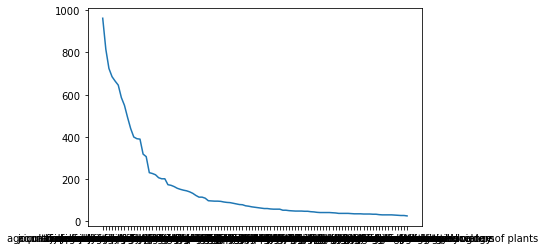

In [197]:
plt.plot(counts["counts"][1:100])

GET NOISE (RANDOM DATA)

In [214]:
from pathlib import Path
from multiprocess import Pool

def get_noise_from_data(path):
    import pandas as pd
    from numpy import random
    test_data =pd.read_json(path, compression="infer", lines=True)
    print(test_data.head(10))
    subset = ["title", "paperAbstract", "authors", "doi", "year", "journalName", "journalVolume", "journalPages", "fieldsOfStudy"]
    #test_data = test_data.loc[: , subset]
    test_data = test_data.loc[(pd.isna(test_data["paperAbstract"])==False) &
                          (test_data["paperAbstract"]!="")].reset_index(drop=True)

    return test_data.loc[random.choice(len(test_data), replace=False, size=50)]

In [221]:
start=3000
end=5999
acc = []
files = Path(".") / "Data Dump"
to_process = list(files.iterdir())
relevant = list(filter(lambda f: f.name.startswith("s2-corpus"), files.iterdir()))[start:end]
func = get_noise_from_data
    
with Pool() as pool:
    acc = pool.map(func,relevant) 

In [222]:
noise_1 = pd.concat(acc, ignore_index=True)

In [223]:
noise_1.to_json("random_data_3000_5999")

In [225]:
noise_2 = pd.read_json("random_data_0_3000")

In [226]:
random_samples = pd.concat([noise_1, noise_2])

In [228]:
random_samples.reset_index(inplace=True, drop=True)

In [229]:
random_samples.to_json("random_data")